In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
processed_dir = TOP +'data/processed/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import genra

In [4]:
df  = pd.read_csv(interim_dir+'oral_10pte_smi_020723.csv', index_col = [0])

In [5]:
df1 = df.set_index('DSSTox_Substance_Id')

In [6]:
df1.shape

(5321, 6)

In [7]:
df2 = pd.read_excel(external_dir+'DSSToxQuery_20231117_REACH.xlsx')

/home/grace/anaconda3/envs/aim_clone/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10034 entries, 0 to 10033
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Query                     10034 non-null  object 
 1   Found_By                  10034 non-null  object 
 2   DSSTox_Substance_Id       9515 non-null   object 
 3   DSSTox_Structure_Id       8480 non-null   object 
 4   DSSTox_QC-Level           9515 non-null   object 
 5   Substance_Name            9515 non-null   object 
 6   Substance_CASRN           9515 non-null   object 
 7   Substance_Type            9515 non-null   object 
 8   Substance_Note            2608 non-null   object 
 9   Structure_SMILES          8480 non-null   object 
 10  Structure_InChI           8471 non-null   object 
 11  Structure_InChIKey        8471 non-null   object 
 12  Structure_Formula         8480 non-null   object 
 13  Structure_MolWt           8480 non-null   float64
 14  Struct

In [9]:
df.columns

Index(['DSSTox_Substance_Id', 'Substance_Name', 'Structure_MolWt',
       'Structure_SMILES', 'Structure_SMILES_2D-QSAR', '10ptile_POD', 'pPOD'],
      dtype='object')

In [10]:
echa_ids = df2['DSSTox_Substance_Id'].tolist()

In [11]:
df3 = df1[df1.index.isin(echa_ids)]

In [12]:
df3.shape

(2187, 6)

In [13]:
df4 = df3.reset_index()

In [14]:
MOLS = dict(zip(df4['DSSTox_Substance_Id'], df4['Structure_SMILES_2D-QSAR']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
Morgan_FP = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
Morgan_FP.index=MOLS.keys()
Morgan_FP.columns = ['mrgn_%d'%i for i in Morgan_FP.columns]

In [15]:
reach_prs = pd.read_csv(external_dir+'reach_pairs.csv', index_col = [0])

In [16]:
reach_prs.columns

Index(['source_DSSTox_Substance_Id', 'source_DSSTox_Structure_Id',
       'source_DSSTox_QC-Level', 'source_Substance_Name',
       'source_Substance_CASRN', 'source_Substance_Type',
       'source_Substance_Note', 'source_Structure_SMILES',
       'source_Structure_InChI', 'source_Structure_InChIKey',
       'source_Structure_Formula', 'source_Structure_MolWt',
       'source_Structure_SMILES_2D-QSAR', 'target_DSSTox_Substance_Id',
       'target_DSSTox_Structure_Id', 'target_DSSTox_QC-Level',
       'target_Substance_Name', 'target_Substance_CASRN',
       'target_Substance_Type', 'target_Substance_Note',
       'target_Structure_SMILES', 'target_Structure_InChI',
       'target_Structure_InChIKey', 'target_Structure_Formula',
       'target_Structure_MolWt', 'target_Structure_SMILES_2D-QSAR',
       'source_qsarsmi', 'target_qsarsmi'],
      dtype='object')

In [17]:
reach_prs = reach_prs[['source_DSSTox_Substance_Id', 'source_Substance_Name','source_Structure_SMILES',
       'source_Structure_InChIKey', 'source_qsarsmi', 
       'source_Structure_Formula', 'source_Structure_MolWt','target_DSSTox_Substance_Id',
       'target_Substance_Name', 
       'target_Structure_SMILES',  'target_Structure_Formula',
       'target_Structure_MolWt','target_Structure_InChIKey',
       'target_qsarsmi']]

In [18]:
reach_prs = reach_prs[(reach_prs['target_qsarsmi'].notnull()) & (reach_prs['source_qsarsmi'].notnull()) ]

In [19]:
targets = reach_prs[['target_DSSTox_Substance_Id', 'target_qsarsmi']]

In [20]:
targets.columns

Index(['target_DSSTox_Substance_Id', 'target_qsarsmi'], dtype='object')

In [21]:
source = reach_prs[['source_DSSTox_Substance_Id', 'source_qsarsmi']]

In [22]:
def mkfp(df, name, smi):
    MOLS = dict(zip(df[name], df[smi]))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
    FP.index=MOLS.keys()
    FP.columns = ['mrgn_%d'%i for i in FP.columns]
    return FP

In [23]:
targets_fp = mkfp(targets, name = 'target_DSSTox_Substance_Id', smi = 'target_qsarsmi')

In [24]:
source_fp = mkfp(source, name = 'source_DSSTox_Substance_Id', smi = 'source_qsarsmi')

In [25]:
all_df = pd.concat([Morgan_FP, targets_fp,source_fp])

In [26]:
all_df

all_df = all_df[~all_df.index.duplicated(keep='first')] 

In [27]:
all_df

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1014,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023
DTXSID001004378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
DTXSID001005033,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
DTXSID001014636,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
DTXSID001016432,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID001019581,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID4036435,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID3041877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
DTXSID1021324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID3026514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from scipy.spatial.distance import pdist, squareform

D_mgrn = pd.DataFrame(squareform(pdist(all_df, 'jaccard')), columns = all_df.index, index = all_df.index)
S_mgrn = 1-D_mgrn
S_mgrn.head()

,DTXSID001004378,DTXSID001005033,DTXSID001014636,DTXSID001016432,DTXSID001019581,DTXSID001020192,DTXSID001020304,DTXSID001020930,DTXSID001033347,DTXSID001033547,...,DTXSID9021689,DTXSID801341700,DTXSID7040154,DTXSID8044202,DTXSID6020224,DTXSID4036435,DTXSID3041877,DTXSID1021324,DTXSID3026514,DTXSID4042254
DTXSID001004378,1.000000,0.145161,0.048387,0.045455,0.120000,0.126582,0.053333,0.041096,0.031250,0.074627,...,0.047619,0.111111,0.086207,0.132075,0.042553,0.096774,0.137931,0.025000,0.019608,0.100000
DTXSID001005033,0.145161,1.000000,0.060606,0.133333,0.072289,0.132530,0.076923,0.065789,0.075758,0.115942,...,0.139535,0.140351,0.133333,0.203704,0.038462,0.140625,0.092308,0.022222,0.017857,0.163934
DTXSID001014636,0.048387,0.060606,1.000000,0.097561,0.050633,0.047619,0.054054,0.056338,0.160714,0.075758,...,0.048780,0.053571,0.050847,0.072727,0.043478,0.063492,0.120690,0.025641,0.108696,0.065574
DTXSID001016432,0.045455,0.133333,0.097561,1.000000,0.032258,0.045455,0.035088,0.056604,0.210526,0.061224,...,0.090909,0.081081,0.102564,0.081081,0.000000,0.043478,0.069767,0.050000,0.000000,0.121951
DTXSID001019581,0.120000,0.072289,0.050633,0.032258,1.000000,0.080808,0.054348,0.044444,0.063291,0.097561,...,0.033333,0.068493,0.038462,0.068493,0.063492,0.088608,0.105263,0.017241,0.060606,0.063291


In [29]:
def nearest_neighbour(S, target, n = 10):
    t_m =S[target].values
    ids_chem = {i:x for i, x in enumerate(S.index)}
    temp_chem = np.argpartition(-t_m, n)
    chem_nn = temp_chem[:n]
    nn_chem = [ids_chem[x] for x in chem_nn]
    mydict = {k:v for k,v in list(zip(nn_chem,t_m[chem_nn]))}
    df = pd.DataFrame(mydict.items(), columns = ['DSSTox_Substance_Id', 'Jaccard']).sort_values(by = 'Jaccard', ascending = False)
    return df

In [30]:
def wtavg(df):
    sim = df.Jaccard
    acts = df.pPOD
    return np.sum(acts.values * sim.values)/np.sum(sim.values)

In [31]:
def pred_genra(S1, target,n,y):
    a = nearest_neighbour(S1, target,n=8 )
    print(a)
    b = y[y.index.isin(a['DSSTox_Substance_Id'])].reset_index()
    print(b)
    c = pd.merge(a, b, on = 'DSSTox_Substance_Id', how = 'left')
    c = c.dropna()
    d = wtavg(c[c['DSSTox_Substance_Id'] != target])
    return d

In [32]:
Y = df3['pPOD']

In [33]:
pred_genra(S_mgrn, 'DTXSID1027269', n = 8, y = Y)

  DSSTox_Substance_Id   Jaccard
0       DTXSID3026932  1.000000
1       DTXSID8027329  1.000000
3       DTXSID4027367  1.000000
4       DTXSID5026914  1.000000
5       DTXSID1027269  1.000000
2       DTXSID6025804  0.826087
6       DTXSID4025402  0.541667
7       DTXSID3037757  0.517241
  DSSTox_Substance_Id      pPOD
0       DTXSID8027329  0.078779


0.0787789352435857

In [34]:
targets_pred = {}
errors = []
for e in targets['target_DSSTox_Substance_Id']:
    try:
        targets_pred[e] = pred_genra(S_mgrn,e,n=8,y=Y)
    except Exception as error:
        print(error)

  DSSTox_Substance_Id   Jaccard
0       DTXSID3026932  1.000000
1       DTXSID8027329  1.000000
3       DTXSID4027367  1.000000
4       DTXSID5026914  1.000000
5       DTXSID1027269  1.000000
2       DTXSID6025804  0.826087
6       DTXSID4025402  0.541667
7       DTXSID3037757  0.517241
  DSSTox_Substance_Id      pPOD
0       DTXSID8027329  0.078779
  DSSTox_Substance_Id   Jaccard
0       DTXSID3026932  1.000000
1       DTXSID8027329  1.000000
3       DTXSID4027367  1.000000
4       DTXSID5026914  1.000000
5       DTXSID1027269  1.000000
2       DTXSID6025804  0.826087
6       DTXSID4025402  0.541667
7       DTXSID3037757  0.517241
  DSSTox_Substance_Id      pPOD
0       DTXSID8027329  0.078779
  DSSTox_Substance_Id   Jaccard
0       DTXSID3026932  1.000000
1       DTXSID8027329  1.000000
3       DTXSID4027367  1.000000
4       DTXSID5026914  1.000000
5       DTXSID1027269  1.000000
2       DTXSID6025804  0.826087
6       DTXSID4025402  0.541667
7       DTXSID3037757  0.517241
  DSSTox

/tmp/ipykernel_1926657/3164661967.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(acts.values * sim.values)/np.sum(sim.values)
/tmp/ipykernel_1926657/3164661967.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(acts.values * sim.values)/np.sum(sim.values)
/tmp/ipykernel_1926657/3164661967.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(acts.values * sim.values)/np.sum(sim.values)


  DSSTox_Substance_Id   Jaccard
0       DTXSID3026932  1.000000
1       DTXSID8027329  1.000000
3       DTXSID4027367  1.000000
4       DTXSID5026914  1.000000
5       DTXSID1027269  1.000000
2       DTXSID6025804  0.826087
6       DTXSID4025402  0.541667
7       DTXSID3037757  0.517241
  DSSTox_Substance_Id      pPOD
0       DTXSID8027329  0.078779
  DSSTox_Substance_Id   Jaccard
6       DTXSID9022528  1.000000
1       DTXSID3042348  0.648649
2       DTXSID4022527  0.648649
0       DTXSID3020209  0.600000
4       DTXSID4022529  0.542857
3       DTXSID9022526  0.500000
5       DTXSID0029133  0.428571
7       DTXSID3026647  0.400000
  DSSTox_Substance_Id      pPOD
0       DTXSID0029133 -0.059107
1       DTXSID3020209  0.244954
2       DTXSID3026647  1.036459
3       DTXSID9022526 -1.118716
  DSSTox_Substance_Id   Jaccard
6       DTXSID9022528  1.000000
1       DTXSID3042348  0.648649
2       DTXSID4022527  0.648649
0       DTXSID3020209  0.600000
4       DTXSID4022529  0.542857
3       

/tmp/ipykernel_1926657/3164661967.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(acts.values * sim.values)/np.sum(sim.values)


  DSSTox_Substance_Id   Jaccard
0      DTXSID50160204  1.000000
1       DTXSID3025542  0.363636
2       DTXSID2020844  0.360000
3       DTXSID8029600  0.347826
4       DTXSID4029145  0.320000
5       DTXSID0024399  0.304348
6       DTXSID1026615  0.300000
7      DTXSID60862404  0.296296
  DSSTox_Substance_Id      pPOD
0       DTXSID0024399 -0.111899
1       DTXSID4029145 -0.356169
  DSSTox_Substance_Id   Jaccard
2       DTXSID4052392  1.000000
1      DTXSID20883711  0.522727
3       DTXSID3044253  0.372549
0       DTXSID6041636  0.367347
4       DTXSID4040763  0.346939
6       DTXSID2047725  0.346154
5       DTXSID3041877  0.339623
7       DTXSID1062043  0.325581
  DSSTox_Substance_Id      pPOD
0       DTXSID1062043  1.377259
1       DTXSID2047725 -0.350779
2      DTXSID20883711  0.137147
3       DTXSID3044253 -0.529520
4       DTXSID4040763  0.228539
5       DTXSID4052392  0.229095
6       DTXSID6041636  0.797082
  DSSTox_Substance_Id   Jaccard
4       DTXSID2021868  1.000000
3       

In [35]:
len(targets_pred)

266

In [36]:
targets_pred = {k:v for k,v in targets_pred.items() if not np.isnan(v) }

In [37]:
len(targets_pred)

265

In [38]:
source_pods = {k:v for k,v in zip(df4[df4['DSSTox_Substance_Id'].isin(source['source_DSSTox_Substance_Id'])]['DSSTox_Substance_Id'], df4[df4['DSSTox_Substance_Id'].isin(source['source_DSSTox_Substance_Id'])]['pPOD'])}

In [39]:
reach_prs['GenRA_pPOD'] = reach_prs['target_DSSTox_Substance_Id'].apply(lambda x: targets_pred[x] if x in targets_pred.keys() else np.nan)

In [40]:
reach_prs['source_pPOD'] = reach_prs['source_DSSTox_Substance_Id'].apply(lambda x: source_pods[x] if x in source_pods.keys() else np.nan)

In [41]:
reach_prs_comparison = reach_prs.dropna(subset =['source_pPOD'])

In [42]:
def ecdf(data):
    '''
    Calculate the ecdf of a 1d-array
    Returns the x, y needed to plot the empirical ecdf
    '''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    return x, y

In [43]:
reach_prs_comparison['diff'] = reach_prs_comparison['source_pPOD'] - reach_prs_comparison['GenRA_pPOD']

/tmp/ipykernel_1926657/3639422152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reach_prs_comparison['diff'] = reach_prs_comparison['source_pPOD'] - reach_prs_comparison['GenRA_pPOD']


In [46]:
reach_prs_comparison.head()

,source_DSSTox_Substance_Id,source_Substance_Name,source_Structure_SMILES,source_Structure_InChIKey,source_qsarsmi,source_Structure_Formula,source_Structure_MolWt,target_DSSTox_Substance_Id,target_Substance_Name,target_Structure_SMILES,target_Structure_Formula,target_Structure_MolWt,target_Structure_InChIKey,target_qsarsmi,GenRA_pPOD,source_pPOD,diff
25,DTXSID0044496,6-Pentyltetrahydro-2H-pyran-2-one,CCCCCC1CCCC(=O)O1,GHBSPIPJMLAMEP-UHFFFAOYNA-N,CCCCCC1CCCC(=O)O1,C10H18O2,170.252,DTXSID9047596,delta-Dodecalactone,CCCCCCCC1CCCC(=O)O1,C12H22O2,198.306,QRPLZGZHJABGRS-UHFFFAOYNA-N,CCCCCCCC1CCCC(=O)O1,0.231382,-0.086219,-0.317601
65,DTXSID9041732,C.I. Pigment Orange 36,CC(=O)C(N=NC1=CC=C(Cl)C=C1[N+]([O-])=O)C(=O)NC...,DLQMNSDNQWLFSS-UHFFFAOYNA-N,CC(=O)C(N=NC1=CC=C(Cl)C=C1[N+]([O-])=O)C(=O)NC...,C17H13ClN6O5,416.780,DTXSID50867488,"Butanamide, N-(2,3-dihydro-2-oxo-1H-benzimidaz...",CC(=O)C(N=NC1=CC=CC=C1C(F)(F)F)C(=O)NC1=CC2=C(...,C18H14F3N5O3,405.337,VBNVBMNKUIJLPP-UHFFFAOYNA-N,CC(=O)C(N=NC1=CC=CC=C1C(F)(F)F)C(=O)NC1=CC2NC(...,-0.222725,-0.079063,0.143662
108,DTXSID8024814,4-Chlorotoluene,CC1=CC=C(Cl)C=C1,NPDACUSDTOMAMK-UHFFFAOYSA-N,CC1=CC=C(Cl)C=C1,C7H7Cl,126.580,DTXSID2033863,"1,4-Divinylbenzene",C=CC1=CC=C(C=C)C=C1,C10H10,130.190,WEERVPDNCOGWJF-UHFFFAOYSA-N,C=CC1C=CC(=CC=1)C=C,0.444140,0.801140,0.357000
109,DTXSID1020431,"1,4-Dichlorobenzene",ClC1=CC=C(Cl)C=C1,OCJBOOLMMGQPQU-UHFFFAOYSA-N,ClC1C=CC(Cl)=CC=1,C6H4Cl2,147.000,DTXSID2033863,"1,4-Divinylbenzene",C=CC1=CC=C(C=C)C=C1,C10H10,130.190,WEERVPDNCOGWJF-UHFFFAOYSA-N,C=CC1C=CC(=CC=1)C=C,0.444140,0.598764,0.154624
158,DTXSID4020371,Dapsone,NC1=CC=C(C=C1)S(=O)(=O)C1=CC=C(N)C=C1,MQJKPEGWNLWLTK-UHFFFAOYSA-N,NC1C=CC(=CC=1)S(=O)(=O)C1C=CC(N)=CC=1,C12H12N2O2S,248.300,DTXSID4041731,C.I. Food Yellow 6,NC1=CC=C(C=C1)N=NC1=CC=C(C=C1)S(O)(=O)=O,C12H11N3O3S,277.300,PPVRMPPLECDING-UHFFFAOYSA-N,NC1C=CC(=CC=1)N=NC1C=CC(=CC=1)S(O)(=O)=O,0.432776,1.141154,0.708379


In [58]:
(10**(-0.040567))*157.213

143.19289026540756

In [59]:
(10**(-3.187099))*1157.213

0.7521670488719628

In [57]:
reach_prs_comparison[reach_prs_comparison['diff'] > 3]

,source_DSSTox_Substance_Id,source_Substance_Name,source_Structure_SMILES,source_Structure_InChIKey,source_qsarsmi,source_Structure_Formula,source_Structure_MolWt,target_DSSTox_Substance_Id,target_Substance_Name,target_Structure_SMILES,target_Structure_Formula,target_Structure_MolWt,target_Structure_InChIKey,target_qsarsmi,GenRA_pPOD,source_pPOD,diff
2326,DTXSID5020027,Acrylamide,NC(=O)C=C,HRPVXLWXLXDGHG-UHFFFAOYSA-N,C=CC(N)=O,C3H5NO,71.079,DTXSID9027443,N-(Butoxymethyl)acrylamide,CCCCOCNC(=O)C=C,C8H15NO2,157.213,UTSYWKJYFPPRAP-UHFFFAOYSA-N,CCCCOCNC(=O)C=C,0.040567,3.187099,3.146533


<AxesSubplot:ylabel='Frequency'>

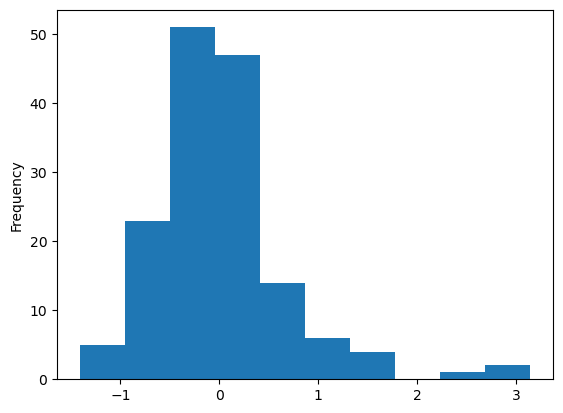

In [52]:
reach_prs_comparison['diff'].plot(kind = 'hist')

In [53]:
reach_prs_comparison.describe()

,source_Structure_MolWt,target_Structure_MolWt,GenRA_pPOD,source_pPOD,diff
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,264.308294,284.665418,0.258918,0.268437,0.009519
std,164.503843,160.880159,0.452871,0.762589,0.665098
min,60.052000,66.051000,-0.435760,-0.929736,-1.413081
25%,135.126000,156.269000,-0.115471,-0.267201,-0.317601
50%,188.182000,217.240000,0.161509,0.095866,-0.068054
75%,407.990000,405.337000,0.519336,0.598764,0.233913
max,879.860000,732.714000,1.557945,3.187099,3.146533


In [60]:
!pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.2-py3-none-any.whl size=12205 sha256=eb317559586bdd35d9f7590456710f7c09a9df440ec647f72f6d28db24a99c82
  Stored in directory: /home/grace/.cache/pip/wheels/79/2e/e2/7d1dbc2477e3f8e0c3df4304677891e1fc50ae7e47a09279e3
Successfully built empiricaldist


In [62]:
from empiricaldist import Cdf

In [63]:
cdf_diff = Cdf.from_seq(reach_prs_comparison['diff'])

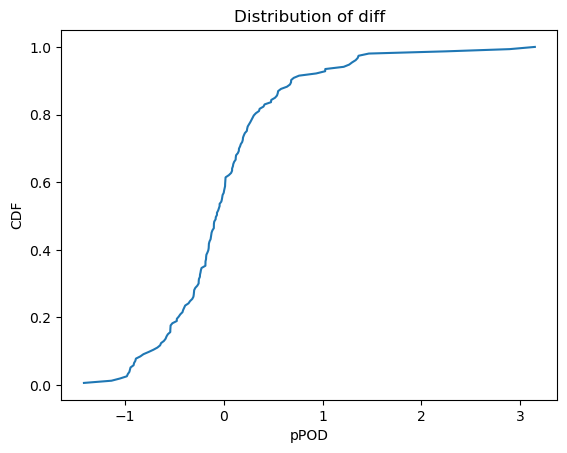

In [64]:
cdf_diff.plot()

plt.xlabel('pPOD')
plt.ylabel('CDF')
plt.title('Distribution of diff');

In [65]:
cdf_diff(0)

array(0.5620915)

Text(0, 0.5, 'ECDF')

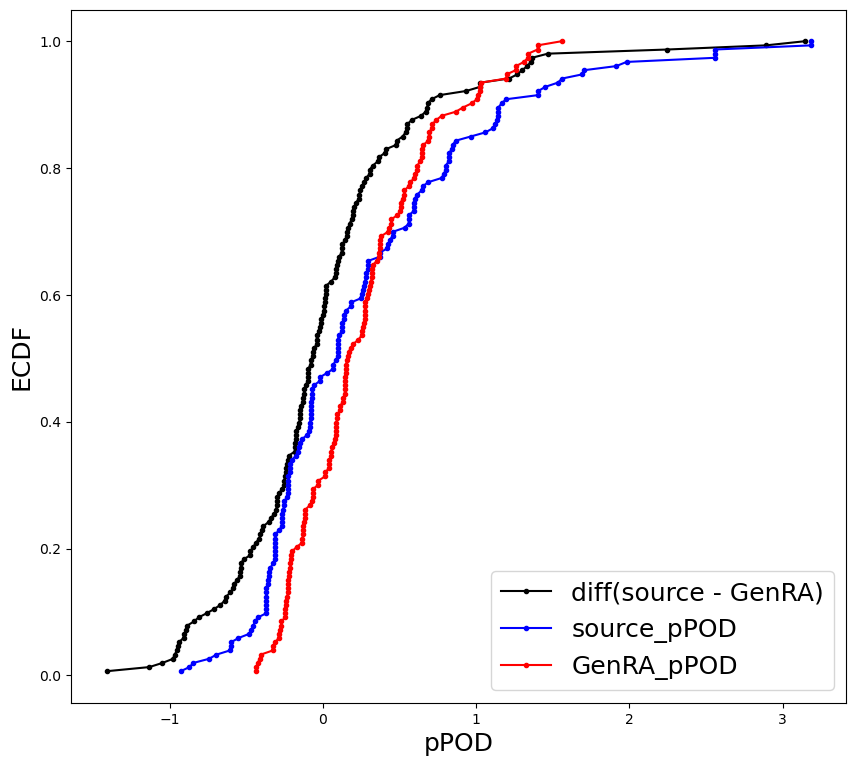

In [44]:
plt.figure(figsize = (10,9))
plt.plot(ecdf(reach_prs_comparison['diff'])[0], ecdf(reach_prs_comparison['diff'])[1], linestyle = None, marker = '.', color = 'black', label = 'diff(source - GenRA)')
plt.plot(ecdf(reach_prs_comparison['source_pPOD'])[0], ecdf(reach_prs_comparison['source_pPOD'])[1], linestyle = None, marker = '.', color = 'blue', label = 'source_pPOD')
plt.plot(ecdf(reach_prs_comparison['GenRA_pPOD'])[0], ecdf(reach_prs_comparison['GenRA_pPOD'])[1], linestyle = None, marker = '.', color = 'red', label = 'GenRA_pPOD')




plt.legend(fontsize = 18)
#plt.xscale('log')
plt.xlabel('pPOD', fontsize = 18)
plt.ylabel('ECDF', fontsize = 18)
#plt.savefig(figures_dir+'echa_genra_toxval.png', dpi = 300)

In [66]:
all_echa = df2[df2['Structure_SMILES'].notnull()]

In [67]:
all_echa.columns

Index(['Query', 'Found_By', 'DSSTox_Substance_Id', 'DSSTox_Structure_Id',
       'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'Substance_Note', 'Structure_SMILES',
       'Structure_InChI', 'Structure_InChIKey', 'Structure_Formula',
       'Structure_MolWt', 'Structure_SMILES_2D-QSAR', 'DateModified'],
      dtype='object')

In [68]:
all_echa_fp = mkfp(all_echa, name = 'DSSTox_Substance_Id', smi = 'Structure_SMILES' )

[22:07:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[22:07:31] Explicit valence for atom # 3 Si, 8, is greater than permitted
[22:07:31] WARNING: not removing hydrogen atom without neighbors
[22:07:31] Explicit valence for atom # 31 N, 4, is greater than permitted
[22:07:31] Explicit valence for atom # 8 O, 3, is greater than permitted
[22:07:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[22:07:31] Explicit valence for atom # 0 O, 3, is greater than permitted
[22:07:31] WARNING: not removing hydrogen atom without neighbors
[22:07:31] Explicit valence for atom # 6 O, 3, is greater than permitted
[22:07:31] Explicit valence for atom # 8 O, 3, is greater than permitted
[22:07:31] WARNING: not removing hydrogen atom without neighbors
[22:07:31] WARNING: not removing hydrogen atom without neighbors
[22:07:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[22:07:31] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:07:31] Can't kekulize mol.  Unkekulized 

In [69]:
all_echa_fp.shape

(8424, 1024)

In [70]:
all_fp = pd.concat([all_echa_fp, targets_fp, source_fp])

In [71]:
all_fp.index.nunique(), all_fp.shape

(8667, (8945, 1024))

In [72]:
all_fp = all_fp[~all_fp.index.duplicated(keep='first')] 

In [73]:
D_chem = pd.DataFrame(squareform(pdist(all_fp, 'jaccard')), columns = all_fp.index, index = all_fp.index)
S_chem= 1-D_chem
S_chem.head()

,DTXSID5024976,DTXSID7022594,DTXSID30198166,DTXSID1021166,DTXSID8024573,DTXSID0020523,DTXSID4024981,DTXSID2043874,DTXSID4049038,DTXSID6035106,...,DTXSID9021689,DTXSID801341700,DTXSID7040154,DTXSID8044202,DTXSID6020224,DTXSID4036435,DTXSID3041877,DTXSID1021324,DTXSID3026514,DTXSID4042254
DTXSID5024976,1.000000,0.065574,0.232558,0.042254,0.081633,0.100000,0.236842,0.088889,0.063830,0.105263,...,0.000000,0.060000,0.056604,0.060000,0.050000,0.070175,0.156863,0.000000,0.184211,0.072727
DTXSID7022594,0.065574,1.000000,0.064516,0.074074,0.100000,0.062500,0.034483,0.087719,0.032787,0.018519,...,0.041667,0.047619,0.131148,0.031250,0.078431,0.072464,0.125000,0.021739,0.160000,0.043478
DTXSID30198166,0.232558,0.064516,1.000000,0.056338,0.058824,0.191489,0.200000,0.111111,0.085106,0.102564,...,0.027027,0.080000,0.075472,0.080000,0.048780,0.107143,0.153846,0.000000,0.121951,0.090909
DTXSID1021166,0.042254,0.074074,0.056338,1.000000,0.056338,0.054795,0.045455,0.075758,0.043478,0.049180,...,0.113208,0.071429,0.068493,0.119403,0.084746,0.106667,0.080000,0.018182,0.046875,0.080000
DTXSID8024573,0.081633,0.100000,0.058824,0.056338,1.000000,0.076923,0.066667,0.086957,0.085106,0.023810,...,0.027027,0.038462,0.000000,0.018868,0.023810,0.050847,0.090909,0.000000,0.179487,0.016949


In [74]:
target_pairs = {}
for target in targets['target_DSSTox_Substance_Id']:
    target_pairs[target] = nearest_neighbour(S_chem, target, n = 10)

In [75]:
S_chem.loc['DTXSID5024976', 'DTXSID7022594']

0.06557377049180324

In [76]:
mylst = []
for x, y in zip(reach_prs['target_DSSTox_Substance_Id'], reach_prs['source_DSSTox_Substance_Id']):
    mylst.append([x, y, S_chem.loc[x,y]])

In [77]:
reach_prs['Jaccard-source-target'] = [e[2] for e in mylst]

In [78]:
reach_prs['all'] = mylst

In [79]:
target_pairs2 = {}
for k,v in target_pairs.items():
      target_pairs2[k] = v[v.DSSTox_Substance_Id != k] 
     

In [80]:
mylst2 = []
for x in (reach_prs['target_DSSTox_Substance_Id']):
    mylst2.append([x,target_pairs2[x].iloc[0,:].values]) 

In [81]:
[e[1][1] for e in mylst2][0]

1.0

In [82]:
reach_prs['closest_source-target'] = [e[1][0] for e in mylst2]
reach_prs['Jaccard_closest_source-target'] = [e[1][1] for e in mylst2]

In [83]:
reach_prs['diff_Jaccard'] = reach_prs['Jaccard_closest_source-target'] - reach_prs['Jaccard-source-target']

In [88]:

cdf_jd = Cdf.from_seq(reach_prs.diff_Jaccard)

In [91]:
cdf_jd

,probs
0.000000,0.243523
0.006010,0.246114
0.006410,0.248705
0.007653,0.251295
0.014264,0.253886
...,...
0.788636,0.987047
0.814286,0.992228
0.884680,0.994819
0.897959,0.997409


In [84]:
reach_prs.diff_Jaccard.value_counts(normalize = True)

0.000000    0.243523
0.458333    0.012953
0.500000    0.012953
0.433333    0.012953
0.173913    0.012953
              ...   
0.292683    0.002591
0.284211    0.002591
0.328375    0.002591
0.315217    0.002591
0.345214    0.002591
Name: diff_Jaccard, Length: 269, dtype: float64

Text(0, 0.5, 'ECDF')

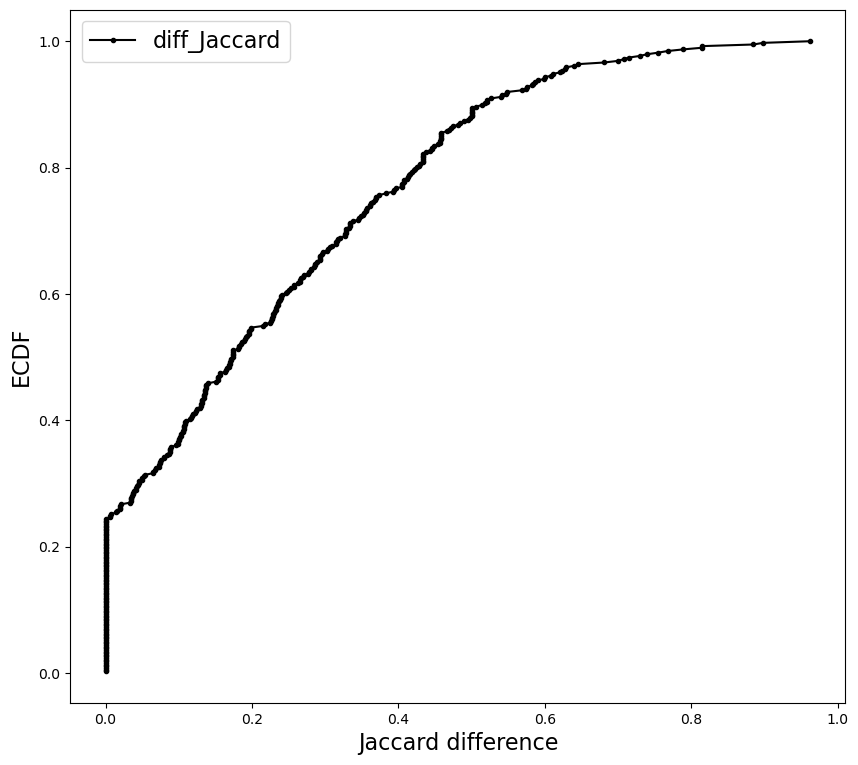

In [85]:
plt.figure(figsize = (10,9))
plt.plot(ecdf(reach_prs['diff_Jaccard'])[0], ecdf(reach_prs['diff_Jaccard'])[1], linestyle = None, marker = '.', color = 'black', label = 'diff_Jaccard')

plt.legend(fontsize = 16)
#plt.xscale('log')
plt.xlabel('Jaccard difference', fontsize = 16)
plt.ylabel('ECDF', fontsize = 16)
#plt.savefig(figures_dir+'echa_genra_toxval.png', dpi = 300)

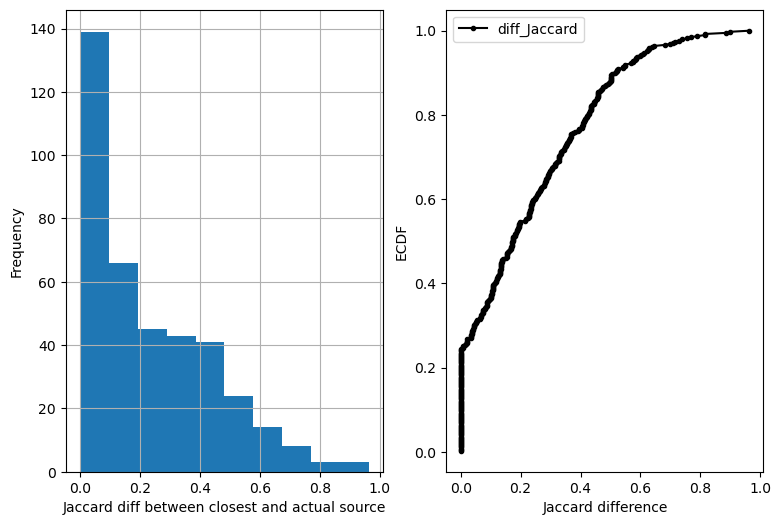

In [228]:
f, ax = plt.subplots(1,2, figsize = (9,6))
reach_prs['diff_Jaccard'].hist(ax = ax[0])
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Jaccard diff between closest and actual source')

ax[1].plot(ecdf(reach_prs['diff_Jaccard'])[0], ecdf(reach_prs['diff_Jaccard'])[1], linestyle = None, marker = '.', color = 'black', label = 'diff_Jaccard', )

ax[1].legend()
#plt.xscale('log')
ax[1].set_xlabel('Jaccard difference')
ax[1].set_ylabel('ECDF', )
#f.savefig(figures_dir+'Jaccard_diff.png', dpi = 300)

In [86]:
reach_prs['diff_Jaccard'].describe()

count    386.000000
mean       0.224218
std        0.214125
min        0.000000
25%        0.009306
50%        0.173913
75%        0.369152
max        0.962264
Name: diff_Jaccard, dtype: float64

In [94]:
final_df3 = pd.read_csv(external_dir+'final_df3_270823.csv', index_col = [0])

In [96]:
final_df3.columns

Index(['dtxsid', 'pred_pPOD', 'MolWeight', 'nbHBdAcc', 'ndHBdDon', 'LogP_pred',
       'pred_POD', 'echa_POD', 'echa_POD_min', 'echa_pPOD',
       'target_DSSTox_Substance_Id', 'target_Substance_Name',
       'target_Structure_SMILES', 'target_Structure_Formula', 'target_qsarsmi',
       'target_Structure_InChIKey'],
      dtype='object')

In [97]:
final_df3[['dtxsid', 'pred_pPOD','pred_POD', 'echa_POD', 'echa_POD_min', 'echa_pPOD']]

,dtxsid,pred_pPOD,pred_POD,echa_POD,echa_POD_min,echa_pPOD
0,DTXSID1027269,0.304890,111.133088,100.000,100.000,0.350733
4,DTXSID5026914,0.389006,68.673367,100.000,100.000,0.225794
8,DTXSID4027367,0.340977,89.487939,100.000,100.000,0.292741
11,DTXSID9047596,0.397844,79.282307,1000.000,1000.000,-0.702980
13,DTXSID401036250,2.097982,3.673025,0.017,0.017,4.432557
...,...,...,...,...,...,...
343,DTXSID4020539,0.862260,26.515351,25.000,14.000,0.887818
345,DTXSID6040111,-0.497168,364.702951,500.000,500.000,-0.634199
347,DTXSID4042206,0.537163,73.514118,11.100,11.100,1.358210
348,DTXSID501104446,0.659219,112.249861,190.000,190.000,0.430651


In [98]:
final_df3['diff'] = final_df3['pred_pPOD'] - final_df3['echa_pPOD'] 

<AxesSubplot:>

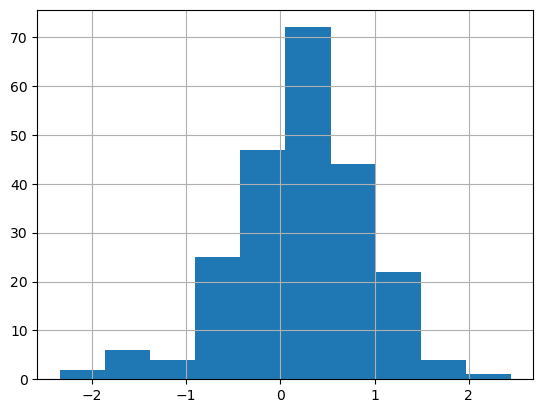

In [99]:
final_df3['diff'].hist()